ESM3 Tut1-3

Quickstart

In [ ]:
from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESM3InferenceClient, ESMProtein, GenerationConfig
import torch
import esm
from esm.sdk import client
login(token="removed")

device = (
    "mps" if torch.backends.mps.is_available()
    else "cpu"
)
#Forge API
model=client("esm3-medium-2024-08",token="removed")

ESM-C

In [ ]:
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
protein = ESMProtein(sequence="AAAA")
client = ESMC.from_pretrained("esmc_300m").to("cpu")

protein_tensor = client.encode(protein)
logits_output = client.logits(
    protein_tensor, LogitsConfig(sequence=True,return_embeddings=True)
)
print(logits_output.logits, logits_output.embeddings)

BATCH FORGE EXECUTOR 

In [ ]:
from esm.sdk.forge import ESM3ForgeInferenceClient
from esm.sdk.api import ESMProtein, LogitsConfig, ESMProteinError, LogitsOutput
from esm.sdk import batch_executor

def embed_sequence(client:ESM3ForgeInferenceClient, sequence: str) -> LogitsOutput:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = client.encode(protein)
    if isinstance(protein_tensor,ESMProteinError):
        raise protein_tensor 
    output = client.logits(protein_tensor,LogitsConfig(sequence=True, return_embeddings=True))
    
    return output 
sequences = ["A","AA","AAA"]
forge_client = ESM3ForgeInferenceClient(model="esmc-6b-2024-12", url="https://forge.evolutionaryscale.ai", token="removed")

with batch_executor() as executor:
    outputs = executor.execute_batch(user_func=embed_sequence, client=forge_client,sequence=sequences)

Tut1: Create an ESMProtein object

An ESMProtein has 5 attributes that represent input (promptable) tracks:

sequence: amino acid sequence

coordinates: 3D coordinates of atoms in each amino acid of the protein

secondary_structure: 8-class secondary structure (SS8)

sasa: solvent-accessible surface area (SASA)

function_annotations: function annotations derived from InterPro

You can prompt an ESM3 model by setting any subset of these tracks to be partially unmasked when calling the model with an ESMProtein instance.

One way to create an ESMProtein object is from a pdb id and chain id from RCSB. Below, we first create a ProteinChain with the pdb id and chain id and then create an ESMProtein from it. This will populate the sequence and coordinates properties.

In [25]:
# Functions for visualizing 3D structure

import py3Dmol


def visualize_pdb(pdb_string):
    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_string, "pdb")
    view.setStyle({"cartoon": {"color": "spectrum"}})
    view.zoomTo()
    view.render()
    view.center()
    return view


def visualize_3D_coordinates(coordinates):
    """
    This uses all Alanines
    """
    protein_with_same_coords = ESMProtein(coordinates=coordinates)
    # pdb with all alanines
    pdb_string = protein_with_same_coords.to_pdb_string()
    return visualize_pdb(pdb_string)


def visualize_3D_protein(protein):
    pdb_string = protein.to_pdb_string()
    return visualize_pdb(pdb_string)

In [26]:
# Slightly modified version of secondary structure plotting code from
# https://www.biotite-python.org/examples/gallery/structure/transketolase_sse.html
# Code source: Patrick Kunzmann
# License: BSD 3 clause

import biotite
import biotite.sequence as seq
import biotite.sequence.graphics as graphics
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle


# Create 'FeaturePlotter' subclasses
# for drawing the secondary structure features
class HelixPlotter(graphics.FeaturePlotter):
    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False

    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2 * np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4 * np.sin(x_val) + 1) / 2

        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2 * np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0

        # Draw white background to overlay the guiding line
        background = Rectangle(
            bbox.p0, bbox.width, bbox.height, color="white", linewidth=0
        )
        axes.add_patch(background)
        axes.plot(x_val, y_val, linewidth=2, color=biotite.colors["dimgreen"])


class SheetPlotter(graphics.FeaturePlotter):
    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width

    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False

    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height / 2
        dx = bbox.width
        dy = 0

        if loc.defect & seq.Location.Defect.MISS_RIGHT:
            # If the feature extends into the previous or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True

        axes.add_patch(
            biotite.AdaptiveFancyArrow(
                x,
                y,
                dx,
                dy,
                self._tail_width * bbox.height,
                self._head_width * bbox.height,
                # Create head with 90 degrees tip
                # -> head width/length ratio = 1/2
                head_ratio=0.5,
                draw_head=draw_head,
                color=biotite.colors["orange"],
                linewidth=0,
            )
        )


# Converter for the DSSP secondary structure elements
# to the classical ones
dssp_to_abc = {
    "I": "c",
    "S": "c",
    "H": "a",
    "E": "b",
    "G": "c",
    "B": "b",
    "T": "c",
    "C": "c",
}


def visualize_secondary_structure(sse, first_id):
    """
    Helper function to convert secondary structure array to annotation
    and visualize it.
    """

    def _add_sec_str(annotation, first, last, str_type):
        if str_type == "a":
            str_type = "helix"
        elif str_type == "b":
            str_type = "sheet"
        else:
            # coil
            return
        feature = seq.Feature(
            "SecStr", [seq.Location(first, last)], {"sec_str_type": str_type}
        )
        annotation.add_feature(feature)

    # Find the intervals for each secondary structure element
    # and add to annotation
    annotation = seq.Annotation()
    curr_sse = None
    curr_start = None
    for i in range(len(sse)):
        if curr_start is None:
            curr_start = i
            curr_sse = sse[i]
        else:
            if sse[i] != sse[i - 1]:
                _add_sec_str(
                    annotation, curr_start + first_id, i - 1 + first_id, curr_sse
                )
                curr_start = i
                curr_sse = sse[i]
    # Add last secondary structure element to annotation
    _add_sec_str(annotation, curr_start + first_id, i + first_id, curr_sse)

    fig = plt.figure(figsize=(30.0, 3.0))
    ax = fig.add_subplot(111)
    graphics.plot_feature_map(
        ax,
        annotation,
        symbols_per_line=150,
        loc_range=(first_id, first_id + len(sse)),
        feature_plotters=[HelixPlotter(), SheetPlotter()],
    )
    fig.tight_layout()
    return fig, ax


def plot_ss8(ss8_string):
    ss3 = np.array([dssp_to_abc[e] for e in ss8_string], dtype="U1")
    _, ax = visualize_secondary_structure(ss3, 1)
    ax.set_xticks([])

In [28]:
#Function annotation track
# Functions for visualizing InterPro function annotations

from dna_features_viewer import GraphicFeature, GraphicRecord
from matplotlib import colormaps

from esm.utils.function.interpro import InterPro, InterProEntryType
from esm.sdk.api import FunctionAnnotation

def visualize_function_annotations(
    annotations: list[FunctionAnnotation],
    sequence_length: int,
    ax: plt.Axes,
    interpro_=InterPro(),
):
    cmap = colormaps["tab10"]
    colors = [cmap(i) for i in range(len(InterProEntryType))]
    type_colors = dict(zip(InterProEntryType, colors))

    features = []
    for annotation in annotations:
        if annotation.label in interpro_.entries:
            entry = interpro_.entries[annotation.label]
            label = entry.name
            entry_type = entry.type
        else:
            label = annotation.label
            entry_type = InterProEntryType.UNKNOWN

        feature = GraphicFeature(
            start=annotation.start - 1,  # one index -> zero index
            end=annotation.end,
            label=label,
            color=type_colors[entry_type],
            strand=None,
        )
        features.append(feature)

    record = GraphicRecord(
        sequence=None, sequence_length=sequence_length, features=features
    )

    record.plot(figure_width=12, plot_sequence=False, ax=ax)

In [ ]:
#3D STRUCTURE TRACK 
from biotite.database import rcsb
from esm.sdk.api import ESMProtein
from esm.utils.structure.protein_chain import ProteinChain
from esm.utils.types import FunctionAnnotation
pdb_id = "1cm4"
chain_id = "A"

# Create a protein using a pdb format file from RCSB
# Note: instead of the next two lines, we could use
# protein_chain = ProteinChain.from_rcsb(pdb_id, chain_id)
# but in future implementations, this function may use the mmcif file
# which would throw off some indices later on in this notebook
str_io = rcsb.fetch(pdb_id, "pdb")
protein_chain = ProteinChain.from_pdb(str_io, chain_id=chain_id, id=pdb_id)
protein = ESMProtein.from_protein_chain(protein_chain)

## We can also load from a local pdb file by passing its path
# protein_chain = ProteinChain.from_pdb('xxxx.pdb', chain_id=chain_id, id=pdb_id)
# The chain_id and id arguments are optional and will be inferred if None
print(protein.sequence)
print(protein.coordinates.shape)
visualize_3D_coordinates(protein.coordinates)

In [ ]:
#SECONDARY STRUCTURE TRACK 
from biotite.structure import annotate_sse
def get_approximate_ss(protein_chain: ProteinChain):
    # get biotite's ss3 representation
    ss3_arr = annotate_sse(protein_chain.atom_array)
    biotite_ss3_str = "".join(ss3_arr)

    # translate into ESM3's representation
    translation_table = str.maketrans(
        {
            "a": "H",  # alpha helix
            "b": "E",  # beta sheet
            "c": "C",  # coil
        }
    )
    esm_ss3 = biotite_ss3_str.translate(translation_table)
    return esm_ss3

protein.secondary_structure = get_approximate_ss(protein_chain)
print(protein.secondary_structure)
plot_ss8(protein.secondary_structure)

In [ ]:
#FUNCTION TRACK 
interpro_function_annotations = [
    FunctionAnnotation(label="IPR050145", start=1, end=142),  # 1 indexed, inclusive;
    FunctionAnnotation(label="IPR002048", start=4, end=75),
    FunctionAnnotation(label="IPR002048", start=77, end=144),
    FunctionAnnotation(label="IPR011992", start=1, end=143),
    FunctionAnnotation(label="IPR018247", start=17, end=29),
    FunctionAnnotation(label="IPR018247", start=53, end=65),
    FunctionAnnotation(label="IPR018247", start=90, end=102),
    FunctionAnnotation(label="IPR018247", start=126, end=138),
]
fig, ax = plt.subplots(figsize=(20.0, 4.0))
visualize_function_annotations(interpro_function_annotations, len(protein), ax)

In [ ]:
#Function keywords
from esm.tokenization import InterProQuantizedTokenizer


def get_keywords_from_interpro(
    interpro_annotations,
    interpro2keywords=InterProQuantizedTokenizer().interpro2keywords,
):
    keyword_annotations_list = []
    for interpro_annotation in interpro_annotations:
        keywords = interpro2keywords.get(interpro_annotation.label, [])
        keyword_annotations_list.extend(
            [
                FunctionAnnotation(
                    label=keyword,
                    start=interpro_annotation.start,
                    end=interpro_annotation.end,
                )
                for keyword in keywords
            ]
        )
    return keyword_annotations_list

protein.function_annotations = get_keywords_from_interpro(interpro_function_annotations)
protein.function_annotations
fig, ax = plt.subplots(figsize=(20.0, 8.0))
visualize_function_annotations(protein.function_annotations, len(protein), ax)

In [ ]:
#SASA PLOT
cmap = colormaps["cividis"]
clip_sasa_lower = 10
clip_sasa_upper = 90


def plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    _, ax = plt.subplots(figsize=(5, 0.3), dpi=350)
    ax.imshow(gradient, aspect="auto", cmap=cmap)
    ax.text(
        0.1,
        -0.3,
        f"{clip_sasa_lower} or lower",
        va="center",
        ha="right",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.3,
        f"{(clip_sasa_lower + clip_sasa_upper) // 2}",
        va="center",
        ha="right",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.9,
        -0.3,
        f"{clip_sasa_upper} or higher",
        va="center",
        ha="left",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper)

# Functions for visualizing SASA as colors on the 3D structure


def get_color_strings(sasa, clip_sasa_lower, clip_sasa_upper, cmap):
    transformed_sasa = np.clip(sasa, clip_sasa_lower, clip_sasa_upper)
    transformed_sasa = (transformed_sasa - clip_sasa_lower) / (
        clip_sasa_upper - clip_sasa_lower
    )
    rgbas = (cmap(transformed_sasa) * 255).astype(int)

    return [f"rgb({rgba[0]},{rgba[1]},{rgba[2]})" for rgba in rgbas]


def visualize_sasa_3D_protein(
    protein, clip_sasa_lower=clip_sasa_lower, clip_sasa_upper=clip_sasa_upper, cmap=cmap
):
    pdb_string = protein.to_pdb_string()
    plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper)
    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_string, "pdb")

    for res_pos, res_color in enumerate(
        get_color_strings(protein.sasa, clip_sasa_lower, clip_sasa_upper, cmap)
    ):
        view.setStyle(
            {"chain": "A", "resi": res_pos + 1}, {"cartoon": {"color": res_color}}
        )
    view.zoomTo()
    view.render()
    view.center()
    return view


In [ ]:
#SASA Track 
protein.sasa = protein_chain.sasa()
plt.plot(protein.sasa)
visualize_sasa_3D_protein(protein)

Tut2: ESMC Embedding + threaded async forge

Since we're embedding more than a few sequences, we're going to use a threaded async call to Forge and let Forge take care of batching and parallelization on the backend.

In [ ]:
#setup
from Bio.SeqIO.FastaIO import SimpleFastaParser
import pandas as pd 
from esm.sdk import client
import os
#token = os.getenv("ESM_API_KEY")
model = client(
    model="esmc-300m-2024-12", url="https://forge.evolutionaryscale.ai", token="removed"
)

from concurrent.futures import ThreadPoolExecutor
from typing import Sequence

from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    ESMProteinError,
    LogitsConfig,
    LogitsOutput,
    ProteinType,
)

EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)


def embed_sequence(model: ESM3InferenceClient, sequence: str) -> LogitsOutput:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    return output


def batch_embed(
    model: ESM3InferenceClient, inputs: Sequence[ProteinType]
) -> Sequence[LogitsOutput]:
    """Forge supports auto-batching. So batch_embed() is as simple as running a collection
    of embed calls in parallel using asyncio.
    """
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(embed_sequence, model, protein) for protein in inputs
        ]
        results = []
        for future in futures:
            try:
                results.append(future.result())
            except Exception as e:
                results.append(ESMProteinError(500, str(e)))
    return results


#Request specific hidden layer
#ESM C 6B's hidden states are really large, so we only allow one specific layer to be requested per API call. This also works for other ESM C models, but it is required for ESM C 6B. Refer to https://forge.evolutionaryscale.ai/console to find the number of hidden layers for each model.
# ESMC_6B_EMBEDDING_CONFIG = LogitsConfig(return_hidden_states=True, ith_hidden_layer=55)

#load example sequence dataset
def read_fasta_fast(fasta_file):
    records = []
    with open(fasta_file) as in_handle:
        for title, seq in SimpleFastaParser(in_handle):
            gene_id = title.split()[0]
            records.append((gene_id, seq, len(seq)))
    return pd.DataFrame(records, columns=["Gene", "Sequence", "Length"])


input = read_fasta_fast("petase_db/sequences/esm3_seq/all_petase_variants.fasta")
seq = input["Sequence"].to_list()
#output = embed_sequence(model, seq)
output = batch_embed(model, seq)


import torch
# we'll summarize the embeddings using their mean across the sequence dimension
# which allows us to compare embeddings for sequences of different lengths
all_mean_embeddings = [
    torch.mean(o.hidden_states, dim=0).squeeze().cpu()
    for o in output
]
# now we have a list of tensors of [num_layers, hidden_size]

#note: TAKES TOO MANY CREDITS AND TOO LONG? 
# ok now it worked because i properly used the input sequence (not a df object)
# and then specified in the embedding config to return a specific hidden layer
# works with both esm3 and esmc model 

[tensor([[-5.3438,  3.7188, -4.9062,  ..., -1.5938,  4.8438, -9.4375],
        [-1.1094,  7.9375,  6.0938,  ...,  5.4375,  0.2930,  0.9336],
        [ 3.0156,  8.2500,  5.8750,  ...,  1.8984,  1.1562, -0.1035],
        ...,
        [-3.0938,  2.8594, -2.9531,  ...,  2.2500,  9.0000, -0.1855],
        [ 3.7969, -0.0659,  2.3125,  ...,  2.7344,  8.1875, -4.4688],
        [-3.6875,  2.6094,  4.4375,  ..., -6.2812,  2.4375, -6.5312]],
       dtype=torch.bfloat16), tensor([[-6.2188,  3.6406, -5.1875,  ..., -1.8750,  4.8438, -9.5625],
        [-1.6406,  8.1250,  6.3125,  ...,  5.3125,  0.0289,  0.6719],
        [ 2.6719,  8.3750,  6.2500,  ...,  2.0781,  1.1250, -0.5117],
        ...,
        [-6.5312,  1.7031, -1.4141,  ...,  3.3438, 11.3750, -0.6016],
        [ 2.3906, -0.4727, -0.3574,  ...,  1.8750,  8.5625, -4.5938],
        [-3.5156,  3.3750,  3.7344,  ..., -7.6875,  1.0547, -6.1562]],
       dtype=torch.bfloat16), tensor([[-6.1562,  3.6406, -5.1562,  ..., -1.8203,  4.8438, -9.5625],
 

Examine the performance of different layer embeddings: 

For this example, we're going to use PCA to visualize whether the embeddings separate our proteins by their structural class. To assess the quality of our PCA, we fit a K means classifier with three clusters, corresponding to the three structural classes of our enzyme, and compute the rand index, a measure of the quality of the clustering.

In [4]:
print(all_mean_embeddings[0])

tensor([[-5.3438,  3.7188, -4.9062,  ..., -1.5938,  4.8438, -9.4375],
        [-1.1094,  7.9375,  6.0938,  ...,  5.4375,  0.2930,  0.9336],
        [ 3.0156,  8.2500,  5.8750,  ...,  1.8984,  1.1562, -0.1035],
        ...,
        [-3.0938,  2.8594, -2.9531,  ...,  2.2500,  9.0000, -0.1855],
        [ 3.7969, -0.0659,  2.3125,  ...,  2.7344,  8.1875, -4.4688],
        [-3.6875,  2.6094,  4.4375,  ..., -6.2812,  2.4375, -6.5312]],
       dtype=torch.bfloat16)


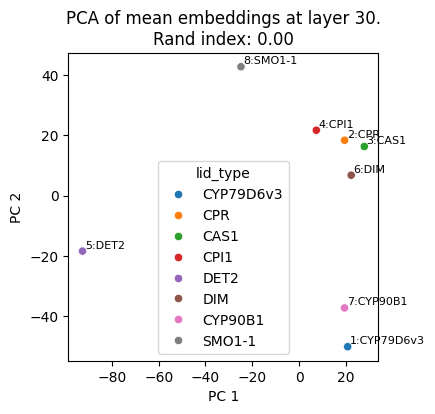

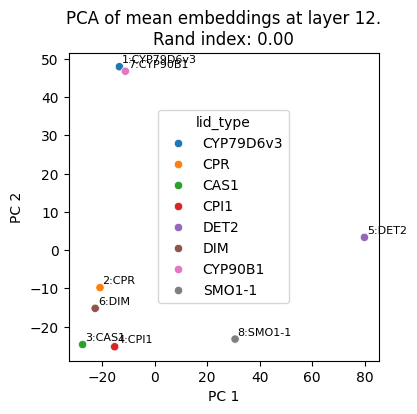

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import numpy as np  # ✅ add these imports for labels

# --- Step 1: Create dummy labels for testing ---
n_sequences = len(all_mean_embeddings)
labels = [
    "CYP79D6v3",          
    "CPR",               
    "CAS1", 
    "CPI1",
    "DET2",
    "DIM",
    "CYP90B1",
    "SMO1-1"
]
df = pd.DataFrame({"lid_type": labels})
# ✅ now df["lid_type"] exists globally and your function can use it

N_KMEANS_CLUSTERS = 3

# --- Step 2: Your plotting function ---
def plot_embeddings_at_layer(all_mean_embeddings: list, layer_idx: int):
    # Stack embeddings across sequences
    stacked_mean_embeddings = torch.stack(
        [embedding[layer_idx, :] for embedding in all_mean_embeddings]
    )
    
    # ✅ Cast to float32 before converting to numpy
    stacked_mean_embeddings = stacked_mean_embeddings.float().cpu().numpy()

    # project all the embeddings to 2D using PCA
    pca = PCA(n_components=2)
    pca.fit(stacked_mean_embeddings)
    projected_mean_embeddings = pca.transform(stacked_mean_embeddings)

    # compute kmeans purity as a measure of how good the clustering is
    kmeans = KMeans(n_clusters=N_KMEANS_CLUSTERS, random_state=0).fit(
        projected_mean_embeddings
    )
    rand_index = adjusted_rand_score(df["lid_type"], kmeans.labels_)

    # plot the clusters
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=projected_mean_embeddings[:, 0],
        y=projected_mean_embeddings[:, 1],
        hue=df["lid_type"],
    )
    plt.title(
        f"PCA of mean embeddings at layer {layer_idx}.\nRand index: {rand_index:.2f}"
    )

    for i, lab in enumerate(labels):
        plt.text(projected_mean_embeddings[i,0] + 1,
             projected_mean_embeddings[i,1] + 1,
             f"{i+1}:{lab}", fontsize=8)
    
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()

# --- Step 3: Call your function ---
plot_embeddings_at_layer(all_mean_embeddings, layer_idx=30)
plot_embeddings_at_layer(all_mean_embeddings, layer_idx=12)

Small exercise - Test each layer in a classifier of enzyme class to see which gives best performance. Not fine-tuned, just a classifier layer on top means fast, less compute, no risk of catastrophic forgetting, can use very large ESM-3 models on modest GPUs. But might underperform vs fine-tuning. If compute allows → try fine-tuning last 2–4 layers of ESM-3 with small LR (not whole model). This is often called “partial fine-tuning” or “adapter tuning.”  Gives you most of the gain without exploding GPU needs.

Example NetsolP:

The output representations of each amino acid in the sequence are averaged to represent the protein and a linear classification layer is used to predict binary solubility.

The trained models have a suffix ‘-F’ and ‘-P’ to indicate whether they are trained end-to-end (fine-tuning) or only the classification layer (pretrained embedding)

The maximum sequence length used for training is 510, by removing around 3.4% of the training sequences that exceed this length, to speed up the training process.For prediction, amino acids after position 1022 are removed due to the maximum length constraints of the transformer models.


Tut3

In [ ]:
from getpass import getpass

import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.graphics as graphics
import matplotlib.pyplot as pl
import py3Dmol
import torch

from esm.sdk import client
from esm.sdk.api import ESMProtein, GenerationConfig
from esm.utils.structure.protein_chain import ProteinChain

token = "1hM3JVqy7zILco2fwPgF9v"
model = client(
    model="esm3-medium-2024-03", url="https://forge.evolutionaryscale.ai", token=token
)
template_gfp = ESMProtein.from_protein_chain(
    ProteinChain.from_rcsb("1qy3", chain_id="A")
)
template_gfp_tokens = model.encode(template_gfp)

print("Sequence tokens:")
print(
    "    ", ", ".join([str(token) for token in template_gfp_tokens.sequence.tolist()])
)

print("Structure tokens:")
print(
    "    ", ", ".join([str(token) for token in template_gfp_tokens.structure.tolist()])
)

prompt_sequence = ["_"] * len(template_gfp.sequence)
prompt_sequence[59] = "T"
prompt_sequence[62] = "T"
prompt_sequence[63] = "Y"
prompt_sequence[64] = "G"
prompt_sequence[93] = "R"
prompt_sequence[219] = "E"
prompt_sequence = "".join(prompt_sequence)

print(template_gfp.sequence)
print(prompt_sequence)

prompt = model.encode(ESMProtein(sequence=prompt_sequence))

# We construct an empty structure track like |<bos> <mask> ... <mask> <eos>|...
prompt.structure = torch.full_like(prompt.sequence, 4096)
prompt.structure[0] = 4098
prompt.structure[-1] = 4097
# ... and then we fill in structure tokens at key residues near the alpha helix
# kink and at the stabilizing R and E positions on the beta barrel.
prompt.structure[55:70] = template_gfp_tokens.structure[56:71]
prompt.structure[93] = template_gfp_tokens.structure[93]
prompt.structure[219] = template_gfp_tokens.structure[219]

print("".join(["✔" if st < 4096 else "_" for st in prompt.structure]))